# Welcome to CS 5242 **Homework 2**

ASSIGNMENT DEADLINE ⏰ : **05 Sept 2022** 

In this assignment, the task is to implement Multi-Layer Perceptron (MLP) for handwritten digit classification from scratch.

Colab is a hosted Jupyter notebook service that requires no setup to use, while providing access free of charge to computing resources including GPUs. In this semester, we will use Colab to run our experiments.

> In this assignment, there is no need to use GPU.

### **Grades Policy**

We have 10 points for this homework. 15% off per day late, 0 scores if you submit it 7 days after the deadline.

### **Cautions**

**DO NOT** use external libraries like PyTorch or TensorFlow in your implementation.

**DO NOT** copy the code from the internet, e.g. GitHub.

---

### **Contact**

Please feel free to contact us if you have any question about this homework or need any further information.

Slack (Recommend): Shenggan Cheng

TA Email: shenggan@comp.nus.edu.sg

> If you have not join the slack group, you can click [here](https://join.slack.com/t/cs5242ay20222-oiw1784/shared_invite/zt-1eiv24k1t-0J9EI7vz3uQmAHa68qU0aw)

## Setup

Start by running the cell below to set up all required software.

In [1]:
!pip install numpy matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Download and extract MNIST Dataset.

In [2]:
!mkdir -p data \
    && wget -q https://raw.githubusercontent.com/Shenggan/cs5242_resource/main/homework2/mnist_data.tar.gz -O ./data/mnist_data.tar.gz \
    && tar xf data/mnist_data.tar.gz -C ./data \
    && rm -rf ./data/mnist_data.tar.gz \
    && ls -l ./data/

total 124872
-rw-r--r-- 1 1000 1000  18289443 Jul 15  2019 mnist_test.csv
-rw-r--r-- 1 1000 1000 109575994 Jul 15  2019 mnist_train.csv


Import the neccesary library.

In [3]:
import time

import numpy as np
import matplotlib.pyplot as plt

Everything is ready, you can move on and ***Good Luck !*** 😃

## Explore MNIST Dataset

One of the first steps when working with a new data set is exploring.Our data here is from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) of `28x28` pixel images of handwritten digits from `0-9`, which has an important place in the history of machine learning.

Our data have been downloaded in the directory `data`: `mnist_train.csv` and `mnist_test.csv`, so the complete file path (from the main directory) are `data/mnist_train.csv` and `data/mnist_test.csv`. 

With that in mind, let's define a helper function `load_data` that we can use to quickly in our data.


In [4]:
def load_data(dir_name):
    """
    Function for loading MNIST data stored in comma delimited files. Labels for 
    each image are the first entry in each row.

    Parameters
    ----------
    dit_name : str
         Path to where data is contained

    Returns
    -------
    X : np.array, np.float32
        A (N x 784) matrix of samples
    Y : np.array, np.float32
        A (N x 1) matrix of labels for each sample
    """
    X, Y = None, None

    # Hint:
    # 1) open the file and iterate through each line
    # 2) in every line, split with ',' and you can get 785 elements
    # 3) as the first number in each sample is the label (0-9), extract that from the rest and return

    # Some numpy function you maybe need to use: `np.array`, `numpy.ndarray.astype`, `numpy.asarray`
    # A kindly example, 
    # tmp_str = "1,2,3,4"
    # array = np.array(line.split(',')).astype(np.float32)
    # print(array)

    # === Complete the code (1')

    # === Complete the code
    return X, Y
  

In [12]:
X_train, Y_train = load_data("./data/mnist_train.csv")
X_test, Y_test = load_data("./data/mnist_test.csv")

An easy to quickly get an idea for how your data looks is to examine the shape of the matrix it's stored using the `.shape` attribute of numpy arrays. We see that the shape of `X_train` is `60000 x 784`, which tells us there are `60000` samples (images) each with dimension `784`. Each sample, typically presented as a 28 x 28 image, is unrolled into a 1-dimensional vector 28 x 28 = 784 contained within each row of `X_train`.

In [13]:
print(f"The shape of the training set is: {X_train.shape[0]} x {X_train.shape[1]}")
print(f"The shape of the test set is: {X_test.shape[0]} x {X_test.shape[1]}")

The shape of the training set is: 60000 x 784
The shape of the test set is: 10000 x 784


Now lets take a look at how the samples are represented, we can do this by calling `Y_train[index]` and `X_train[index]` (here I choose `index=0` to look at the very first sample). We first notice `Y_train[0]=5.0`, meaning this entry is the digit `5`. We will confirm this shortly by visualizing some of these samples. We then notice each entry is an integer (cast into `np.float32` in our `load_data` function) ranging from `0-255`. This representation is common when working with images. The numerical entries are interpreted as pixel intensities typically shown in gray-scale ranging between `0` (black) and `255` (white). 

In [14]:
index = 0
print(f"Y_train[{index}]: {Y_train[index]}")
print(f"X_train[{index}] range from {min(X_train[index])} to {max(X_train[index])}.")

Y_train[0]: 5.0
X_train[0] range from 0.0 to 255.0.


In [15]:
# rescale data between 0 - 1.0
def scale_data(X):
    X_scaled = None
    # === Complete the code (0.5')

    # === Complete the code
    return X_scaled

X_train = scale_data(X_train)
X_test = scale_data(X_test)

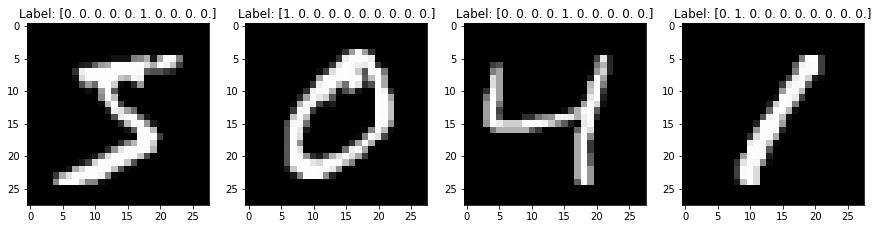

In [16]:
y_train_onehot = np.zeros((Y_train.size, int(Y_train.max()) + 1))
y_test_onehot = np.zeros((Y_test.size, int(Y_test.max()) + 1))

# one-hot encode train (y_train) and test (y_test) set labels
# === Complete the code (0.5')

# === Complete the code

num_images = 4
fig, axes = plt.subplots(1, num_images, figsize=(15, 10))
for image, label, ax in zip(X_train[:num_images], y_train_onehot[:num_images], axes):
    ax.imshow(image.reshape(28, 28), cmap='gray', vmin=0, vmax=1.0)
    ax.set_title(f"Label: {label}")

## Implementation of Multilayer perceptron

We'll first go through and write the code for each piece of an MLP (**without bias**) in generic Python functions. We'll then wrap everything in an `MLP` class, which will allow us to easily access all the MLP functionality in a user friendly manner.

### Feed Forward

Implementing the forward pass of the neural network is relatively simply as everything is basically just a series of matrix multiplicaitons and activation functions. A two-layer MLP example we looked at when working through the math had a forward pass which mathematically took the form:
$$\sigma(\mathbf{x}W^{(1)})W^{(2)}$$

We'll of course want to make things a bit more modular by allowing the user to choose some of the neural network paramters, such as the number of hidden layers `L` and the nunber of neurons per layer `N_l`. For simplicity we'll restrict that all the hidden layers are treated with **sigmoid** activaitons.

The last step of process for classification tasks is actually producing a prediction from these numbers in the output layer. Typically, in the case of multi-label classification, this is done using a *softmax* activation function which effectively converts the output neurons into probabilities for each label. This has the mathematical form, $$\text{softmax}(\mathbf{z})_j = \frac{\exp(z_j)}{\sum_{k=0}^{K=9}\exp{(z_k)}}$$.

The softmax activation function has the property of the outputs summing to 1 $\sum_{k=1}^{K=9}\text{softmax}(\mathbf{z}^{(2)})_k = 1$, allowing each output $\mathbf{a}^{(2)}_i = \text{softmax}(\mathbf{z}^{(2)})_i$ to be interpreted as the probability that the input is actually a digit `0-9`. Note, the output of a MLP does not need to have a softmax activation, for example in a regression setting a softmax activation would not make much sense. When evaluating the classification accuracy of the neural network, the input is typically classified according to the output label with the highest probability, 

$$\text{prediction}(\mathbf{x}) = \text{argmax}\  \text{softmax}(\mathbf{z}^{(2)}) = \text{argmax}\  \text{softmax}((\sigma(\mathbf{x}W^{(1)})W^{(2)}))$$.

We can start by simply defining our activation functions:

In [17]:
def sigmoid(x):
    """
    Compute the sigmoid of `x`, calculated element-wise

    Parameters
    ----------
    x : float or array_like
        input

    Returns
    -------
    sigmoid(x) : float or array_like
        sigmoid applied to `x` element-wise
    """
    result = None
    # === Complete the code (0.5')

    # === Complete the code
    return result

In [18]:
def softmax(x):
    """
    Compute the softmax of `x`,

    Parameters
    ----------
    x : array_like
        (N x dim) array with N samples by p dimensions. dim=10 for MNIST classification. 

    Returns
    -------
    softmax(x) : float or array_like
        softmax applied to `x` along the first axis.
    """
    result = None
    # === Complete the code (0.5')

    # === Complete the code
    return result

The inputs `x`, weight matricies `w`, and activations are in principle all we need to define the forward pass; however, for efficency reasons we'll want to store the outputs of the hidden layer neurons when performing the forward pass. Storing these values will help us later more quickly calculate the gradients during the backward pass. The `init_layers` functions will initalize these hidden layers as NumPy arrays, doing this before we begin training will help us save some overhead we would otherwise inccur reinitalizing these hidden layers before each forward pass. These hidden layer values will be stored in multi-dimensional matricies, called *tensors*. One dimension of these tensors will be the `batch size` which will indicate the number of samples simultaneously passed to MLP during one training loop (feed forward + backpropagation).

In [19]:
def init_layers(batch_size, layer_sizes):
    """
    Initalize arrays to store the hidden layer ouputs.

    Parameters
    ----------
    batch_size : int
        Number of samples to concurrently feed through the network.
    layer_sizes : array_like
        Array of length `N_l`. Each entry is the number of neurons in each layer.

    Returns
    -------
    hidden_layers : list
        List of empty arrays used to hold hidden layer outputs. 
    """
    hidden_layers = [np.empty((batch_size, layer_size)) for layer_size in layer_sizes]
    return hidden_layers

In order to perform a forward pass our input `x` is consequtively multiplied by weight matricies passed into the associated activaiton functions. The paramters in these weight matricies will ultimately be learned through backpropagation, but each weight matrix must first be initalized to random values. There are a number of different methods for doing this initalization, but for the moment we'll use a simple approach of just drawing the numerical values from a normal distribution with mean zero and standard deviation 1. We could have also reasonably choosen to simply draw from a uniform distribution on the range `[-1,1]`. 

In [20]:
def init_weights(layer_sizes):
    """
    Initalize the paramters of the weight matricies.

    Parameters
    ----------
    layer_sizes : array_like
        Array of length `N_l`. Each entry is the number of neurons in each layer.

    Returns
    -------
    weights : array_like
        Randomly initalized weight matricies based on the layer sizes. 
    """
    weights = list()
    for i in range(layer_sizes.shape[0] - 1):
        weights.append(np.random.uniform(-1, 1, size=[layer_sizes[i], layer_sizes[i + 1]]))
    return weights

### Backpropagation

Initalizing all the weights, layers, and activations prior to the forward pass makes much of the backward pass implimentation actually quite simple. For convinience we'll define a `sigmoid_derivative` function, which simply computes the derivative of the sigmoid activation $\sigma^{\prime}$. We'll use this when computing the gradients during the backward pass.

In [21]:
def sigmoid_derivative(sigmoid_out):
    """
    Calculate derivative of sigmoid activation based on sigmoid output.

    Parameters
    ----------
    sigmoid_out : array_like
        Output values processed by a sigmoid function.
    
    Returns
    -------
    sigmoid_derivative(h) : array_like
        Derivative of sigmoid, based on value of sigmoid.
    """
    result = None
    # === Complete the code (0.5')

    # === Complete the code
    return result

### Training

You have **three tasks** in this section.

1. You need to implement `__feed_forward` function.
2. You need to implement `__back_prop` function.
3. You need to implement the main loop of `train` function.

In [22]:
def to_categorical(x, class_num):
    # Transform probabilities into categorical predictions row-wise, by simply taking the max probability
    categorical = np.zeros((x.shape[0], class_num))
    categorical[np.arange(x.shape[0]), x.argmax(axis=1)] = 1
    return categorical

def accuracy(y_pred, y):
    # Compute the accuracy along the rows, averaging along the number of samples
    return np.all(y_pred == y, axis=1).mean()

def loss(y_pred, y):
    # Compute the loss along the rows, averaging along the number of samples
    loss_ = ((-np.log(y_pred)) * y).sum(axis=1).mean()
    return loss_

class MLP():

    def __init__(self, X, Y, X_val, Y_val, L=1, N_l=128):
        self.X = X
        self.Y = np.squeeze(np.eye(10)[Y.astype(int).reshape(-1)])
        self.X_val = X_val
        self.Y_val = np.squeeze(np.eye(10)[Y_val.astype(int).reshape(-1)])
        self.L = L
        self.N_l = N_l
        self.n_samples = self.X.shape[0]
        self.layer_sizes = np.array([self.X.shape[1]] + [N_l] * L + [self.Y.shape[1]])
        self.__init_weights()
        self.train_loss = list()
        self.train_acc = list()
        self.val_loss = list()
        self.val_acc = list()
        self.train_time = list()
        self.tot_time = list()
        self.metrics = [
            self.train_loss, self.train_acc, self.val_loss, self.val_acc, self.train_time,
            self.tot_time
        ]

        self.class_num = self.Y.shape[1]

    def __init_weights(self):
        # Initialize the weights of the network given the sizes of the layers
        self.weights = list()
        for i in range(self.layer_sizes.shape[0] - 1):
            self.weights.append(
                np.random.uniform(-1, 1, size=[self.layer_sizes[i], self.layer_sizes[i + 1]]))
        self.weights = np.asarray(self.weights)

    def __init_layers(self, batch_size):
        # Initialize and allocate arrays for the hidden layer activations
        self.__h = [np.empty((batch_size, layer)) for layer in self.layer_sizes]

    def __feed_forward(self, batch):
        # Perform a forward pass of `batch` samples (N_samples x N_features)
        out_ = None
        h_l = batch
        self.__h[0] = h_l
        # === Complete the code (1.5')

        # === Complete the code
        self.__out = out_

    def __back_prop(self, batch_y):
        # Update the weights of the network through back-propagation
        # === Complete the code (1.5')

        # === Complete the code

    def predict(self, X):
        # Generate a categorical, one-hot, prediction given an input X
        self.__init_layers(X.shape[0])
        self.__feed_forward(X)
        return to_categorical(self.__out, self.class_num)

    def evaluate(self, X, Y):
        # Evaluate the performance (accuracy) predicting on X with true labels Y
        prediction = self.predict(X)
        return accuracy(prediction, Y)

    def train(self, batch_size=8, epochs=25, lr=1.0):
        # Train the model with a given batch size, epochs, and learning rate. Store and print relevant metrics.
        self.lr = lr
        self.batch_size = batch_size
        for epoch in range(epochs):
            start = time.time()

            self.__init_layers(self.batch_size)
            shuffle = np.random.permutation(self.n_samples)
            train_loss = 0
            train_acc = 0
            X_batches = np.array_split(self.X[shuffle], self.n_samples / self.batch_size)
            Y_batches = np.array_split(self.Y[shuffle], self.n_samples / self.batch_size)
            for batch_x, batch_y in zip(X_batches, Y_batches):
                # === Complete the code (1.5')

                # === Complete the code

            train_loss = (train_loss / len(X_batches))
            train_acc = (train_acc / len(X_batches))
            self.train_loss.append(train_loss)
            self.train_acc.append(train_acc)

            train_time = round(time.time() - start, 3)
            self.train_time.append(train_time)

            self.__init_layers(self.X_val.shape[0])
            self.__feed_forward(self.X_val)
            val_loss = loss(self.__out, self.Y_val)
            val_acc = accuracy(to_categorical(self.__out, self.class_num), self.Y_val)
            self.val_loss.append(val_loss)
            self.val_acc.append(val_acc)

            tot_time = round(time.time() - start, 3)
            self.tot_time.append(tot_time)

            print(
                f"Epoch {epoch+1}: loss = {train_loss.round(3)} | acc = {train_acc.round(3)} | val_loss = {val_loss.round(3)} | val_acc = {val_acc.round(3)} | train_time = {train_time} | tot_time = {tot_time}"
            )


Great, now let's give this a try. Let's create a really simple MLP with only a single hidden layer `L=2` with 64 neurons `N_l=64`. We'll train with a `batch_size=8` for `epochs=20` and a learning rate `lr=0.2`.

In [23]:
model = MLP(X_train, Y_train, X_test, Y_test, L=2, N_l=64)
model.train(batch_size=8, epochs=20, lr=0.2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 1: loss = 0.395 | acc = 0.878 | val_loss = 0.235 | val_acc = 0.928 | train_time = 7.467 | tot_time = 7.587
Epoch 2: loss = 0.206 | acc = 0.937 | val_loss = 0.202 | val_acc = 0.937 | train_time = 7.279 | tot_time = 7.392
Epoch 3: loss = 0.157 | acc = 0.953 | val_loss = 0.167 | val_acc = 0.95 | train_time = 7.247 | tot_time = 7.36
Epoch 4: loss = 0.13 | acc = 0.96 | val_loss = 0.151 | val_acc = 0.953 | train_time = 7.232 | tot_time = 7.345
Epoch 5: loss = 0.111 | acc = 0.966 | val_loss = 0.158 | val_acc = 0.954 | train_time = 7.228 | tot_time = 7.341
Epoch 6: loss = 0.096 | acc = 0.97 | val_loss = 0.142 | val_acc = 0.958 | train_time = 7.29 | tot_time = 7.41
Epoch 7: loss = 0.085 | acc = 0.973 | val_loss = 0.142 | val_acc = 0.959 | train_time = 7.774 | tot_time = 7.889
Epoch 8: loss = 0.073 | acc = 0.977 | val_loss = 0.157 | val_acc = 0.958 | train_time = 7.282 | tot_time = 7.396
Epoch 9: loss = 0.066 | acc = 0.979 | val_loss = 0.137 | val_acc = 0.961 | train_time = 7.241 | tot_tim

Text(0, 0.5, 'Accuracy')

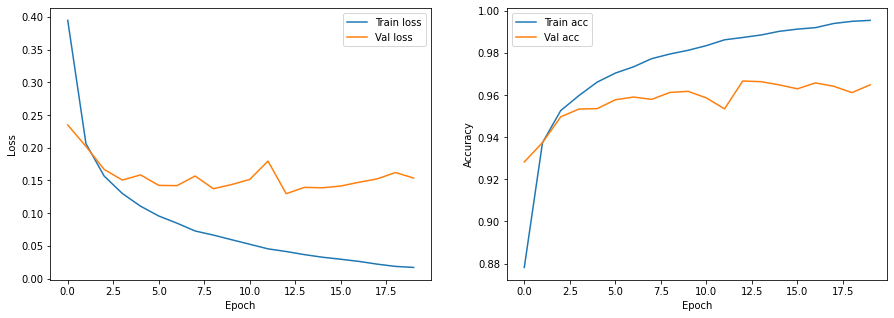

In [24]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(model.train_loss,label="Train loss")
ax[0].plot(model.val_loss,label="Val loss")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")

ax[1].plot(model.train_acc,label="Train acc")
ax[1].plot(model.val_acc,label="Val acc")
ax[1].legend()
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")

## Discussion (2 points)

In this section, you are free to choose some of the following directions to explore, and try to summarize some patterns and conclusions.

* Try to use different learning rates and generalize the impact of learning rate on training.
* Try to use different number of layers of MLPs or different number of neurons of MLPs (including different ways of weight initialization) and explore the impact on the final classification performance.
* Try to use a portion of the data for training (e.g., 10%, 20%, 50%) to explore the training convergence and final classification performance with different amounts of data.

> **NOTE:** *Good Disscusion* include experimental setup, presentation of experimental results including visualization, analysis and interpretation of phenomena, and summary of conclusions

In [ ]:
# === Complete the code (2')

# === Complete the code

Write down your analysis and conclusions:

